<a href="https://colab.research.google.com/github/SolinSM/GAN/blob/main/CGAN_Model_v1__to_test_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CGAN**

## **libraries**
Run this line for first run

!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12

In [ ]:
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12

#for read csv file
import os
import pandas as pd
import numpy as np
import random

# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


# Pre-processing and tokenization
import nltk     # for stop word
import logging
logging.getLogger('nltk').setLevel(logging.CRITICAL)   # Suppress NLTK download messages
nltk.download('punkt', quiet=True)      # quiet=True -> Download packages if needed in silent
nltk.download('stopwords', quiet=True)  # Download packages if needed in silent
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer  # for tokenization  & WordPunctTokenizer --> splits words based on punctuation boundaries.



import sklearn
# Train-test split
from sklearn.model_selection import train_test_split      # for divide data to (train / test/ validate)

# Encoding and Vectorization
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing


# CGAN and Neural Network Models
import tensorflow as tf
#from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
    LSTM
)
#from tensorflow.keras.optimizers import Adam
import keras
from keras.optimizers import Adam
import keras.backend as K


# Plotting
import matplotlib.pyplot as plt


# time and progress
import time
#from tqdm import tqdm
from tqdm.notebook import tqdm  # Progress bar for Jupyter notebooks


# for Evaluate
from sklearn.metrics import classification_report


# Clean and memory usage
import gc       # Clear Variables: Use garbage collection
import psutil   # Check the memory usage in Colab


In [ ]:
print(tf. __version__)          # tensorflow version   2.15.0
!python --version               # python version    3.10.12
print(sklearn.__version__)      # scikit-learn version    1.2.2
print(keras.__version__)        # keras version    2.15.0

2.15.0
Python 3.10.12
1.2.2
2.15.0


## **definition**

In [ ]:

BATCH_SIZE = 128      #30     # batch_size = 16
NUM_EPOCHS = 500      #1000   # epoch_count = 50

NUM_DISCRIMINATORS = 1
#GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)
g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



"""
# Save losses for plotting
cd_real_losses = []   # Real Data D losses
cd_fake_losses = []   # Fake data D losses
cd_losses      = []   # discriminator (D) losses
cg_losses      = []   # generator losses
"""



'\n# Save losses for plotting\ncd_real_losses = []   # Real Data D losses\ncd_fake_losses = []   # Fake data D losses\ncd_losses      = []   # discriminator (D) losses\ncg_losses      = []   # generator losses\n'

## **Color list + TextStyle**

In [ ]:
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


## **Read Multi Files csv**

In [ ]:
""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent, max_rows = 0):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Read CSV Files ------------{TextStyle.RESET_ALL}")

    files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

    if not files:   #if files == []:
      print('Not found any csv files')
      return pd.DataFrame()  # Return an empty DataFrame if no files are found
    else:
      print('Your files are: ', files)


    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        #df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        if max_rows == 0:
            num_rows = int(total_rows * (percent / 100))
            print('Total rows in df/file 100%: ', num_rows)

        elif max_rows > total_rows:
            num_rows = int(total_rows)
            print('Total rows in df/file: ', num_rows)

        else:
            # Calculate how many rows to read from this file
            num_rows = int(max_rows)
            print('Total rows in df/file: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df.head)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


#""" ----------------- Apply Code ----------------- """
#dataset_directory = "/content/datasets"   #files_path
#percent = 100
#data = read_csv_files(dataset_directory,percent)


## **Decode Payload**

Note: It can be tricky to differentiate between base64 and normal text with short strings like "cdiz" because it could theoretically be either.

In [ ]:
import base64
import urllib.parse
import re

### ------------- Decode functions (unicode_decode / url_decode / base64_decode / unicode_url_decoding) ------------- ###
def unicode_decode(str):
  return str.encode('utf-8').decode('unicode-escape') , 'unicode_decode'

def url_decode(str):
  # Regex to match '%XX' where XX is two hexadecimal digits
  is_url_encoded = bool(re.search(r'%[0-9A-Fa-f]{2}', str))
  if is_url_encoded :
      #return urllib.parse.unquote(str)
      try:
        decoded_text = urllib.parse.unquote(str)

        # Check if the decoded str makes sense
        if decoded_text != str:
            return decoded_text, "url_decode"
      except Exception:
        pass
      return str, "nomal"


def base64_decode(base64_string):
  base64_bytes = base64_string.encode("utf-8")
  sample_string_bytes = base64.b64decode(base64_bytes)
  sample_str = sample_string_bytes.decode("utf-8")
  return sample_str , 'base64'

"""
def base64_decode(sql_payload):
  return  base64.b64decode(sql_payload).decode('utf-8') , 'base64'
"""

def unicode_url_decoding(sql_payload):

  if '%20' in sql_payload or '%' in sql_payload:
    try:
      d_payload, payload_type = url_decode(sql_payload)
    except: # Exception as e:
      #print(f"Decoding error in - unicode_url_decoding() - with: {e}")
      d_payload = sql_payload
      payload_type = 'normal'

  elif sql_payload.startswith(('\\u', '\\U', '\\\\u', '\\\\U')) :
    try:
      sql_payload = sql_payload.replace("\\\\", "\\")
      d_payload, payload_type = unicode_decode(sql_payload)
      payload_type = 'unicode_decode'
    except: # Exception as e:
      d_payload = sql_payload
      payload_type = 'normal'

  else:
    d_payload = sql_payload
    payload_type = 'normal'

  return d_payload, payload_type



### ------------- Decode function ------------- ###
def decode_payload(sql_payload):
  if sql_payload[-1] == '=' and sql_payload[-2] == '=':         # when base64 end with ==
    try:
      base64_payload = base64_decode(sql_payload)               # 1. base64 decode
      if base64_payload != sql_payload :
        decode_payload, payload_type = unicode_url_decoding(base64_payload)
        payload_type = '' if payload_type == 'normal' else payload_type
        payload_type = 'base64_' + payload_type
      else:
        decode_payload, payload_type = unicode_url_decoding(sql_payload)
    except Exception as e:
        decode_payload, payload_type = unicode_url_decoding(sql_payload)

  else:
    #sql_payload += '=='     # when base64 NOT end with == add it
    try:
      base64_payload = base64_decode(sql_payload)
      if base64_payload !=  sql_payload :
        decode_payload, payload_type = unicode_url_decoding(base64_payload)
        payload_type = '' if payload_type == 'normal' else payload_type
        payload_type = 'base64_' + payload_type
      else:
        decode_payload, payload_type = unicode_url_decoding(sql_payload)
    except Exception as e:
      #sql_payload = sql_payload[:-2]      # remove last 2 chat == added in this section
      decode_payload, payload_type = unicode_url_decoding(sql_payload)

  #decode_payload = decode_payload.lower()

  return decode_payload , payload_type


### ------------- main ------------- ###
# Example usage:
sql_payload = "\\u0053\\u0045\\u004C\\u0045\\u0043\\u0054\\u0020\\u002A\\u0020\\u0046\\u0052\\u004F\\u004D\\u0020\\u0075\\u0073\\u0065\\u0072\\u0073\\u0020\\u0057\\u0048\\u0045\\u0052\\u0045\\u0020\\u0075\\u0073\\u0065\\u0072\\u006E\\u0061\\u006D\\u0065\\u003D\\u0027\\u006A\\u006F\\u0068\\u006E\\u0027\\u003B"   # unicode encoded
#sql_payload = "SELECT%20*%20FROM%20users%20WHERE%20username%3D%27john%27%3B"    # url encoded
#sql_payload = "U0VMRUNUICogRlJPTSB1c2VycyBXSEVSRSB1c2VybmFtZT0nam9obic7=="      # base64 encoded
#sql_payload = "U0VMRUNUJTIwKiUyMEZST00lMjB1c2VycyUyMFdIRVJFJTIwdXNlcm5hbWUlM0QlMjdqb2huJTI3JTNC"   # base64 + url encoded
#sql_payload = "XHUwMDUzXHUwMDQ1XHUwMDRDXHUwMDQ1XHUwMDQzXHUwMDU0XHUwMDIwXHUwMDJBXHUwMDIwXHUwMDQ2XHUwMDUyXHUwMDRGXHUwMDREXHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDczXHUwMDIwXHUwMDU3XHUwMDQ4XHUwMDQ1XHUwMDUyXHUwMDQ1XHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDZFXHUwMDYxXHUwMDZEXHUwMDY1XHUwMDNEXHUwMDI3XHUwMDZBXHUwMDZGXHUwMDY4XHUwMDZFXHUwMDI3XHUwMDNC"      # base64 + unicode encoded
#sql_payload = "XHUwMDUzXHUwMDQ1XHUwMDRjXHUwMDQ1XHUwMDQzXHUwMDU0XHUwMDIwXHUwMDJhXHUwMDIwXHUwMDQ2XHUwMDUyXHUwMDRmXHUwMDRkXHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDczXHUwMDIwXHUwMDU3XHUwMDQ4XHUwMDQ1XHUwMDUyXHUwMDQ1XHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDZlXHUwMDYxXHUwMDZkXHUwMDY1XHUwMDNkXHUwMDI3XHUwMDZhXHUwMDZmXHUwMDY4XHUwMDZlXHUwMDI3XHUwMDNi=="   # base64 + unicode encoded

#sql_payload = "cdiz"
print("Befor Decoded payload:", sql_payload)

decoded_payload , payload_type = decode_payload(sql_payload)
if decoded_payload:
    print("After Decoded payload:", decoded_payload, '  :::  ', payload_type)
else:
    print("Unable to decode payload using any method.")

Befor Decoded payload: \u0053\u0045\u004C\u0045\u0043\u0054\u0020\u002A\u0020\u0046\u0052\u004F\u004D\u0020\u0075\u0073\u0065\u0072\u0073\u0020\u0057\u0048\u0045\u0052\u0045\u0020\u0075\u0073\u0065\u0072\u006E\u0061\u006D\u0065\u003D\u0027\u006A\u006F\u0068\u006E\u0027\u003B
After Decoded payload: SELECT * FROM users WHERE username='john';   :::   unicode_decode


## **Pre-process Functions**

### **Tokenization + filter_stop_words**

In [ ]:
## ----- filter_stop_words ------ ##
"""
Filters stop words from a list of tokens, keeping words in the exception list.
Args:
    word_tokens: A list of tokens (words).
    except_stop_word: A set of stop words to be excluded from removal (optional).
Returns:
    A list of tokens with stop words removed, except for those in the exception list.
"""
def filter_stop_words(word_tokens):
    stop_words = set(stopwords.words('english'))  # Load default stop words
    except_stop_word = set(['and', 'or', 'where', 'from', 'over'])  # Exception list defined here

    filtered_sentence = []
    for w in word_tokens:
        if w in except_stop_word or w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence





## ----- Tokenization ------ ##
"""
# Tokenization + stop word
Handle Main column in dataset 'sentence'
by encoding it using (Tokenization handlling OOV + stop_word  , TfidfVectorizer )
OOV :
    ensures any new words in the test data are mapped to a common OOV token.
    ensure robustness and accuracy when dealing with new, unseen words.
"""
def tokenization_text(sentences, x_name = ''):      #sentences):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Tokenization + stop word (" , x_name , f") ------------{TextStyle.RESET_ALL}")

    #sentences = X['sentence']
    print('sentences: ' , len(sentences) )

    #define OOV token text to use it when new token appear and not in train tokens data
    #oov_token='<OOV>'

    tokenizer = WordPunctTokenizer()
    #tokenizer.oov_token = '<UNK>'   # '<OOV>'
    tokens = []

    for sentence in sentences:
        #word_tokens = word_tokenize(sentence)
        word_tokens = tokenizer.tokenize(sentence)

        # Replace OOV words with the specified token
        #word_tokens_with_oov = [token if token in tokenizer.vocab else oov_token for token in word_tokens]

        # stop_words  (filter tokeniz word by remove any stop word with except some word as from, where ... etc)
        filtered_tokens = filter_stop_words(word_tokens)


        ########tokens.extend(filtered_tokens)    ## for test 8:18 20-5-2024    #######
        tokens.append(filtered_tokens)

        # Join tokens back to string for TF-IDF
        #tokens.append(' '.join(filtered_tokens))


    #print('len tokens before unique: ', len(tokens))
    #print('1 tokens: ', tokens )

    # Get unique tokens ( Remove duplicates using set() and convert back to list )
    ######tokens = list(set(tokens))    #######
    #print('len tokens after unique: ', len(tokens))
    #print('2 tokens: ', tokens )

    print("tokens len:", len(tokens) )
    """
    i = 0
    for token in tokens:
      if i < 5:
        print("tokens:", tokens[i])
        i = i + 1
      else:
        break
    """
    return tokens



### **one_hot_encoder**

In [ ]:
## ----- one_hot_encoder_func ------ ##

def one_hot_encoder_func(X, one_hot_cols):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform one-hot encoding ------------{TextStyle.RESET_ALL}")
    one_hot_encoded_df = X.copy()

    # Perform one-hot encoding
    one_hot_encoded_1 = pd.get_dummies(one_hot_encoded_df, columns=one_hot_cols, prefix=one_hot_cols)
    #print('one_hot_encoded : ', one_hot_encoded_1)

    # Get only columns that is original columns and needed as them + not neet to convert them from boolean to int
    origin_needed_cols = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                            not any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Get only columns that created new by one-hoe-encoder (get_dummies)
    one_hot_cols_df = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                          any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Convert one_hot_cols_df values from boolean to integers (1 and 0)
    one_hot_cols_df = one_hot_cols_df.astype(int)

    # Concatenate the one_hot_cols_df with the origin_needed_cols
    X = pd.concat([origin_needed_cols, one_hot_cols_df], axis=1)
    print('end one hot encoder : \n', X.head())

    """
      Ex of previous row:
          i  color  size              i     color_blue   color_red   size_M   size_S
          ---------------           ---------------------------------------------------
          0   red    S                0         0            1          0       1
          1   blue   M          ==>   1         1            0          1       0
          2   blue   S                2         1            0          0       1
    """

    return X


### **target_encode**

In [ ]:
## ----- target_encode ------ ##

"""
  # target encoding/mean encoding
  # useful for encoding categorical features into numerical features based on their relationship with the target variable.
  # target_column : deciding it will depend on the objective of your analysis or model training.
  # It is typically the variable you're trying to predict in a supervised learning task.

  NOTE::
    Target-encode might not be ideal for SQL sentences
      1. SQL sentences are unstructured text data with potentially high cardinality and no inherent ordering.
      2. Target encoding works better for categorical variables with a clear relationship to the target,
          rather than free-form text.
"""
def target_encode(X, y, target_encode_cols, target_column):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform target encoding ------------{TextStyle.RESET_ALL}")

    target_encoded_df = X.copy()
    print('target_encoded_df: ', target_encoded_df.head())

    # this colum choisen because it is needed to predict sentence is normal or sqli
    #target_column = class_Col # y   #encoding_col
    for col in target_encode_cols:

        # Check if the column exists
        if col not in X.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

        # Concate y  --> class_Col to X now then next remove it
        #class_Col_df = y.copy()
        X = pd.concat([X, y], axis=1)

        # Calculate the mean target value for each category  (the mean float no for each category in column)
        mean_encoding = X.groupby(col)[target_column].mean()
        print('mean_encoding: ', mean_encoding.head())

        # Map the mean values back to the DataFrame
        target_encoded_df[col + '_encoded'] = X[col].map(mean_encoding)
        #print('target_encoded_df: ', target_encoded_df.head())

        # Drop class_Col added to do this part
        X = X.drop(target_column, axis=1)

        # Drop the original categorical column
        target_encoded_df = target_encoded_df.drop(col, axis=1)
        print('target_encoded_df: ', target_encoded_df.head())

        X = target_encoded_df

    return X



## **CGAN Pre-process**

In [ ]:

def load_and_preprocess_data1(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()


    """
    # ------------------------------------ Decode Sentence ------------------------------------ #
    # Initialize an empty list to store the results
    decoded_sentences = []
    payload_types = []

    for sentence in df_data['sentence']:
        decoded_sentence, payload_type = decode_payload(sentence)
        decoded_sentences.append(decoded_sentence)
        payload_types.append(payload_type)

    # Update the DataFrame with decoded sentences and payload types
    #df_data['origin_sentence'] = df_data['sentence']
    df_data['sentence'] = decoded_sentences
    """


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- separate target from predictors -------{TextStyle.RESET_ALL}")

    # Step 1 : define targent column name and no. class in it
    class_Col = 'attack_type'
    n_classes = df_data[class_Col].nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()

    # Step 2: define datatype for columns
    df_data['len_payload'] = df_data['len_payload'].astype(int)


    if df_data[class_Col].dtype == 'object' :
        y_datatype = 'object'
        # Step 3: Convert Target Column 'attack_type'
        # 3.1 : Convert the 'attack_type' column to One-hot encode
        #encoder = OneHotEncoder(sparse=False)
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_attack_type = encoder.fit_transform(df_data[[class_Col]])
        encoded_attack_type_df = pd.DataFrame(encoded_attack_type, columns=encoder.get_feature_names_out([class_Col]))

        # 3.2 : Concatenate the encoded attack_type with the original DataFrame
        df_data = pd.concat([df_data.drop(class_Col, axis=1), encoded_attack_type_df], axis=1)
        df_data1_copy = df_data.copy()

        # Step 4: Identify the feature columns (X) and the target columns (y)
        # Assuming the target columns are all the one-hot encoded columns (with 'attack_type_' prefix)
        # Automatically find the target columns based on the columns added during encoding
        target_columns = [col for col in df_data.columns if col.startswith('attack_type_')]

        # Features are all the other columns
        feature_columns = [col for col in df_data.columns if col not in target_columns]

        df_data1 = df_data[feature_columns]
        y = df_data[target_columns]
        X = df_data1

    else:
        y_datatype = 'int'
        df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
        y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)

        # remove y column (class_Col) from data columns list
        df_data1 = df_data.copy()
        df_data1.drop(columns=[class_Col], inplace=True)         #X.drop([class_Col], axis=1, inplace=True)
        #X_columns = df_data1.columns       #['sentence', 'len_payload', ....]
        X = df_data1


    print('X : ' , X)
    print('y: ', y)
    #print('y cols: ', y.columns)
    #y_columns = [col for col in y.columns]
    #print('y_columns: ', y_columns)

    """
    ###### Not used in out datasets ######
    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Handling Categorical Features -------{TextStyle.RESET_ALL}")

    # all categorical columns (any column with object dataType ant its value not number)
    categorical_cols = [cname for cname in X.columns if
                        X[cname].dtype == "object"]
    print("Categorical columns len: ", len(categorical_cols))
    print("Categorical columns: ", categorical_cols)

    # Columns that will be one-hot encoded
    # X[cname].nunique() < 4   : less that 4 categories in the column
    one_hot_cols = [cname for cname in X.columns if
                      X[cname].nunique() < 4 and
                      X[cname].dtype == "object"]
    print('one_hot_cols : ', one_hot_cols)
    print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

    # Skip this columns because it needs to use TfidFVectorizer With it
    skip_cols = [main_text_col]

    # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
    target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
    print('target_encode_cols : ', target_encode_cols)
    print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


    # Encode categorical columns if there is any
    if(len(categorical_cols) > 0):

      # to perform one-hot encoding on specified columns of a DataFrame.
      if(len(one_hot_cols)> 0):
        X = one_hot_encoder_func(X, one_hot_cols)

      if(len(target_encode_cols) > 0):
        target_column = class_Col
        X = target_encode(X, y, target_encode_cols, target_column)

    else:
      print("No categorical columns, nothing todo")
    """



    # ------------------------------------ train_test_split ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Divide the dataset into training (70%) and testing (30%) -------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Training data:\n")
    print("X_train : \n", X_train.head , '\n')
    print("y_train : \n", y_train.head)

    if y_datatype == 'int':
        y_train = pd.DataFrame(y_train, columns=[class_Col])
        y_test  = pd.DataFrame(y_test,  columns=[class_Col])

    print(f"Training rows (70% of Dataset)", "X_train shape: " , X_train.shape , " -- y_train shape: ", y_train.shape)
    print(f"Testing rows (30% of Dataset)", "X_test shape: " , X_test.shape , " -- y_test shape: ", y_test.shape)

    print('X_train head: ', X_train.head)
    print('y_train head: ', y_train.head)

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    origin_x_train = X_train
    origin_x_test = X_test



    # ------------------------------------ Tokenization (sentence) ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Tokenization -------{TextStyle.RESET_ALL}")

    X_train_tokenized = tokenization_text(X_train['sentence'], 'x_train')
    X_test_tokenized = tokenization_text(X_test['sentence'], 'x_test')

    # Join tokens back into strings for each sentence
    X_train_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]     #X_train_copy['sentence_joined'] = ' '.join(X_train_tokenized)
    X_test_joined_sentences = [' '.join(tokens) for tokens in X_test_tokenized]
    #/print('joined_sentences: ' , joined_sentences)



    # ------------------------------------ TfidfVectorizer (sentence) ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- TfidfVectorizer -------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Set max_features to 50 for simplicity (Limit to top 100 features)  #dtype='float32'

    ## --- X_train
    # With Tokenization Step  ( X_train_joined_sentences )   AND   without Tokenization step ( X_train['sentence'] )
    X_tfidf_values = tfidf_vectorizer.fit_transform(X_train_joined_sentences)
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    X_train_tfidf_df = pd.DataFrame(X_tfidf_values.toarray(), columns=X_tfidf_selected_features)     #X_df_tfidf
    """ ## old before 29/11/2024
    df_x_train = X_train.copy()
    df_x_train.drop(columns=['sentence'], inplace=True)
    X_train_tfidf_df = pd.DataFrame(X_tfidf_values.toarray(), columns=X_tfidf_selected_features)
    x_train_data = pd.concat([df_x_train, X_train_tfidf_df], axis=1)      # Concatenate TF-IDF features with the original data excluding the sentence column
    """
    ## --- X_test
    # without Tokenization step ( X_test['sentence'] )  # With Tokenization Step  ( X_test_joined_sentences )
    X_test_tfidf_values = tfidf_vectorizer.transform(X_test_joined_sentences)
    X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    X_test_tfidf_df = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)
    """ ## old before 29/11/2024
    df_x_test = X_test.copy()
    df_x_test.drop(columns=['sentence'], inplace=True)
    X_test_tfidf_df = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)
    x_test_data = pd.concat([df_x_test, X_test_tfidf_df], axis=1)       # Concatenate TF-IDF features with the original data excluding the sentence column
    """
    print('end tfidf')




    # ------------------------------------ MinMaxScaler (other cols ignore sentence) ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Scaling Features using 'MinMaxScaler' -------{TextStyle.RESET_ALL}")
    scaler = MinMaxScaler()
    """ ## old before 29/11/2024
    X_train_scaled = scaler.fit_transform(x_train_data)     #, axis=1)
    X_test_scaled = scaler.transform(x_test_data)           #, axis=1)

    # Convert the scaled numerical features back to DataFrames
    x_train_data = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df
    x_test_data = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df
    """

    ## --- X_train (len_payload)
    len_payload_scaled_train = scaler.fit_transform(X_train[['len_payload']])    # Only scale the 'len_payload' column
    len_payload_scaled_train_df = pd.DataFrame(len_payload_scaled_train, columns=['len_payload_scaled'])

    #X_train_tfidf_scaled = scaler.fit_transform(x_train_data)     # Only scale the TF-IDF Data --- (because we used GAN Model and tanh in generator)
    #x_tfidf_train_data = pd.DataFrame(X_train_tfidf_scaled, columns=X_train_tfidf_df.columns)     #X_train_scaled_df

    ## --- X_test (len_payload)
    len_payload_scaled_test = scaler.fit_transform(X_test[['len_payload']])    # Only scale the 'len_payload' column
    len_payload_scaled_test_df = pd.DataFrame(len_payload_scaled_test, columns=['len_payload_scaled'])

    #X_test_tfidf_scaled = scaler.fit_transform(x_test_data)     # Only scale the TF-IDF Data --- (because we used GAN Model and tanh in generator)
    #x_tfidf_test_data = pd.DataFrame(X_test_tfidf_scaled, columns=X_test_tfidf_df.columns)        #X_test_scaled_df



    ## new in 29/11/2024
    # ------------------------------------ Combine all features (TF-IDF + scaled len_payload)) ------------------------------------ #
    # Step 11.6: Combine all features (TF-IDF + scaled len_payload) to DataFrames
    x_train_data = pd.concat([X_train_tfidf_df, len_payload_scaled_train_df], axis=1)
    x_test_data = pd.concat([X_test_tfidf_df, len_payload_scaled_test_df], axis=1)




    # ------------------------------------ PCA for feature selection ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- PCA for feature selection -------{TextStyle.RESET_ALL}")
    #pca = PCA(n_components=50)  # Reduce to 50 components
    pca = PCA(n_components=0.95, random_state=453)    #0.95

    ## ------>> X_train << ------ ##
    print('pca x_train data')
    X_train_pca = pca.fit_transform(x_train_data)     # Fit & Transform PCA on the training data

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data
    x_train_data = X_train_pca_df
    print('end x_train_data')


    ## ------>> X_test << ------ ##
    print('pca x_test data')
    X_test_pca = pca.transform(x_test_data)
    test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=test_pca_feature_names)
    x_test_data = X_test_pca_df
    print('end x_test_data')



    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    #print('explained_variance_ratio: ', explained_variance_ratio)
    #print('cumulative_variance: ', cumulative_variance)


    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)

    # Optional: Save the plot as an image (empty content)
    # Define the path where you want to save the plot
    save_path = '/content/datasets/pca_plot.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)    # Make sure the directory exists
    plt.savefig(save_path)

    plt.show()

    print('x_train_data head', x_train_data.head)
    print('X_train_pca_df shape: ', x_train_data.shape)
    print('x_test_data shape: ', x_test_data.shape)


    return n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test , y_datatype



## **Implement CGAN Models**

### **build_generator**

In [ ]:

def build_generator(input_dim, num_classes):   # vocabulary_size / num_class
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_generator ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  noise = Input(shape=(input_dim,), name='noise')     # latent space noise (Features , ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # no need for One-hot encoded label, its numeric
  concatenated = Concatenate()([noise, label])        # Concatenate(axis=-1) is defualt
  print('len noise: ', noise.shape[1])

  # Embedded layer to map noise to lower-dimensional space, It creates a vector representation for the generated point.
  hidden = Embedding(input_dim, num_classes // 2)(concatenated)  # Adjust embedding dim as needed

  # Hidden layers with ReLU activation and dropout
  hidden = Dense(256, activation='relu')(concatenated)  #(hidden)
  hidden = Dropout(0.2)(hidden)       # 0.1

  hidden = Dense(128, activation='relu')(hidden)
  hidden = Dropout(0.2)(hidden)

  hidden = Dense(64, activation='relu')(hidden)
  hidden = Dropout(0.2)(hidden)

  hidden = Dense(32, activation='relu')(hidden)
  hidden = Dropout(0.2)(hidden)

  # Output layer with Softmax activation
  generated_text = Dense(input_dim, activation='sigmoid', name='generated_text')(hidden)      #softmax with categoies
  print('generated_text shape: ', generated_text.shape)

  # Create the generator model
  generator_model = Model(inputs=[noise, label], outputs=generated_text, name='generator')

  generator_model.compile(
      loss='binary_crossentropy', #'categorical_crossentropy',
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),   # 0.0001  ,  (0.5, 0.999)
      metrics=['accuracy']
  )

  return generator_model

### **build_discriminator**

In [ ]:

def build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_discriminator (", name , f") ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  data  = Input(shape=(input_dim,), name='data')       # Features    (ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # Tf-IDF Vectorizer not One-hot encoded label
  concatenated = Concatenate()([data, label])   #Concatenate(axis=-1) is defualt
  print('len data: ', data.shape[1])

  # Hidden layers with LeakyReLU activation and dropout
  # These layers extract the features
  hidden = data
  for i in range(num_hidden_layers):
    if i == 0:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(concatenated)
      hidden = Dense(neurons_per_layer[i])(concatenated)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
    else:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(hidden)   ##negative_slope  === alpha
      hidden = Dense(neurons_per_layer[i])(hidden)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
      # Consider adding for training stability (important) but this will make disc summary non-trainable params != 0
      #hidden = BatchNormalization()(hidden)

  ## Flatten ?!

  # Output layer for real vs fake prediction (Real/fake classification)
  validity_output = Dense(1, activation='sigmoid', name='validity_output')(hidden)

  # Output layer for class label prediction (normal/sqli attack classification)   (Auxiliary classification / class_output)
  auxiliary_output = Dense(num_classes, activation='sigmoid', name='auxiliary_output')(hidden)

  print('ttsm - real/fake validity_output : ', validity_output)
  print('ttsm - normal/sqli auxiliary_output : ', auxiliary_output)

  # Build and compile the discriminator model
  discriminator_model = Model(inputs=[data, label], outputs=[auxiliary_output, validity_output], name=name)    # inputs=data

  # auxiliary_output (attack_type maybe) may binary_crossentropy  (0 --> normal / 1 --> SQLi)
  #'auxiliary_output': 'categorical_crossentropy', // binary_crossentropy
  discriminator_model.compile(
      loss={'auxiliary_output': 'binary_crossentropy', 'validity_output': 'binary_crossentropy'},
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics={'auxiliary_output': 'accuracy', 'validity_output': 'accuracy'})

  return discriminator_model


### **create_combined_model**

In [ ]:

def build_combined_model(input_dim, num_classes, generator_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_combined_model ------------{TextStyle.RESET_ALL}")

    print('comb 0')
    # functional API model has its input shape, it is suited for more complex models, accepting branches, concatenations, etc.
    #noise = Input(shape=(input_dim,))
    noise_data  = Input(shape=(input_dim,), name='noise_data')
    labels = Input(shape=(num_classes,), name='labels')
    print('labels sm : ', labels)

    # Generator output features for the discriminator
    generated_data = generator_model([noise_data, labels])      # generated_features
    print('generated_data len sm : ', generated_data.shape)

    print('comb 1')
    # Define list for Discriminator outputs for the generated data
    discriminators_class_outputs =[]
    discriminators_validity_outputs =[]

    """ With loop (num of Disc. (3 Disc)  ) """
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    for discriminator in discriminators_model:
        # Freeze discriminator (Freeze Trainable Parameters) -> this make lots params non-trainable
        # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
        discriminator.trainable = False

    """
        ## Why Lists and not Concatenate Directly?
        ## Concatenating directly within the loop might lead to issues if the discriminators have
        ## slightly different output shapes (e.g., due to variations in architecture).
    """
    # another way (not in loop) see -->  ##### Comment 1 #####
    for discriminator in discriminators_model:
        # Discriminator Output for (class label prediction) and (validity --> real vs fake prediction)
        class_outputs , validity_outputs = discriminator([generated_data, labels])
        ##$$$$$$$class_outputs , validity_outputs = discriminator.predict([generated_data, labels])
        discriminators_class_outputs.append(class_outputs)
        discriminators_validity_outputs.append(validity_outputs)



    discriminators_outputs = {
                                'class': discriminators_class_outputs,
                                'validity': discriminators_validity_outputs
                            }


    # discriminators_outputs[class][0]  => discriminator 0 , [1] disc 1 , [2] disc 2
    print('comb 2')
    print('shap disc class output discriminators_outputs[class]: ', discriminators_outputs['class'] )
    print('shap disc validity output discriminators_outputs[validity]: ', discriminators_outputs['validity'] )
    print('shap disc class output discriminators_outputs[class][0]: ', discriminators_outputs['class'][0] )
    print('shap disc class output: ', discriminators_outputs['class'][0].shape[-1] )

    print('discriminators_outputs : ', discriminators_outputs)



    print('comb 3')
    # Concatenate discriminators outputs
    concatenated_discriminator_class_outputs = Concatenate()(discriminators_class_outputs)
    concatenated_discriminator_validity_outputs = Concatenate()(discriminators_validity_outputs)


    print('comb 4')
    # Output for class label prediction
    class_output = Dense(num_classes, activation='sigmoid', name='comb_class_output')(concatenated_discriminator_class_outputs)   #e_class_output)

    # Output for real vs fake prediction
    validity_output = Dense(1, activation='sigmoid', name='comb_validity_output')(concatenated_discriminator_validity_outputs)    #e_validity_output)


    print('comb 5')
    # Build the combined model
    combined_model = Model(inputs=[noise_data, labels],outputs=[class_output,validity_output], name='Combined_Model_CGAN')
    print('comb 6')

    combined_model.compile(
        loss={'comb_class_output': 'binary_crossentropy', 'comb_validity_output': 'binary_crossentropy'},  # categorical_crossentropy
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
        metrics={'comb_class_output': 'accuracy', 'comb_validity_output': 'accuracy'}  #['accuracy']  #
    )
    print(77)

    return combined_model


### **print_models_summary**

In [ ]:
def print_models_summary(generator_model, combined_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (CGAN): \n{TextStyle.RESET_ALL}")
    generator_model.summary(show_trainable=True,expand_nested=True)

    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (CGAN): \n{TextStyle.RESET_ALL} ")
        discriminator.summary(show_trainable=True,expand_nested=True)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (CGAN):\n{TextStyle.RESET_ALL} ")
    combined_model.summary(show_trainable=True)



### **plot_architecture**

In [ ]:
!pip install pydot
!pip install graphviz

from keras.utils import plot_model
from IPython.display import Image     # Display the plot in Colab
def plot_architecture(generator_model, combined_model, discriminators_model):

    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Plot Architecture ------------{TextStyle.RESET_ALL}")
    dataset_directory = "/content/datasets"   #files_path


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator Plot (CGAN): \n{TextStyle.RESET_ALL}")
    plot_file_path1 = os.path.join(dataset_directory, 'generator_model_plot.png')
    plot_model(generator_model, show_shapes=True, to_file=plot_file_path1, show_layer_names=True)
    Image(plot_file_path1)


    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminator " , i , f" Plot (CGAN): \n{TextStyle.RESET_ALL} ")
        plot_file_path2 = os.path.join(dataset_directory, 'discriminator_model_plot.png')
        plot_model(discriminator, show_shapes=True, to_file=plot_file_path2, show_layer_names=True)
        Image(plot_file_path2)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model Plot (CGAN):\n{TextStyle.RESET_ALL} ")
    plot_file_path3 = os.path.join(dataset_directory, 'combined_model_plot.png')
    plot_model(combined_model, show_shapes=True, to_file=plot_file_path3, show_layer_names=True)
    Image(plot_file_path3)


## **Train CGAN**

In [ ]:
import time

# input_dim = latent_dim = noise_dim

def train_cgan(batch_size, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
          X_train, y_train, NUM_EPOCHS):

  #X_train = np.array(X_train)  #.values.tolist()   #.toarray()  #to_numpy()   #csr_matrix.toarray
  #y_train = np.array(y_train)   #.values.tolist()   #.toarray()  #to_numpy()
  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()

  # Save losses for plotting
  d0_real_losses = []   # left discriminator losses   (disc 0)
  d0_fake_losses = []   # left discriminator losses   (disc 0)
  d0_losses      = []   # discriminator losses        (disc 0)
  g_losses       = []   # generator losses
  d_losses       = []   # discriminator losses


  # -----------> Epochs <---------- #
  for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch", unit="epoch"):
      d_loss_list = []
      g_loss_list = []
      start = time.time()


      # ----> Sample real data with length/shape = batch_size
      #print(1)
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      real_data   = X_train[idx]
      real_labels = y_train[idx]
      #print('real_data len sm : ', len(real_data))   #print("Real Data Shape:", real_data.shape)  # Should print (128, input_dim)


      #print(2)
      # Ensure real_labels has the correct shape
      one_hot_encoder = OneHotEncoder(sparse_output=False)
      one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
      #print('one_hot_labels shape: ', one_hot_labels.shape)
      real_labels = one_hot_labels[idx]
      #print('len one-hot real_labels: ', len(real_labels))        #128
      #print('len one-hot real_labels 10: ', real_labels[:10])       # [ [1. 0.] [1. 0.] [0. 1.] .... ]



      # ----> Sample Generate fake data using the generator with length/shape = batch_size
      #print(3)
      noise = np.random.normal(0, 1, (batch_size, noise_dim))
      #real_labels1 = real_labels #np.random.normal(0, 2,size=(batch_size, num_classes))
      generated_data = generator_model.predict([noise, real_labels], verbose='0')
      #print("generated_data (Fake Data) Shape:", generated_data.shape)  # Should print (128, input_dim)
      #print('3 b')




      # ---------------------
      #  Train Discriminator
      # ---------------------
      """
      #To ensure that the discriminator receives both real and fake data in the correct proportions:
      #Real Data: Labelled as 1 (indicating real).
      #Fake Data: Labelled as 0 (indicating fake)
      """
      #print('4')
      valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
      fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

      # -------->   Disc 0   <--------- #
      #print('4 disc 0')
      disc_loss_real_0 = discriminators_model[0].train_on_batch( [real_data, real_labels], {'auxiliary_output': real_labels, 'validity_output': valid })[0]
      disc_loss_fake_0 = discriminators_model[0].train_on_batch( [generated_data, real_labels], {'auxiliary_output': real_labels, 'validity_output': fake })[0]
      d_loss_0 = 0.5 * np.add(disc_loss_real_0, disc_loss_fake_0)   #take average loss from real and fake images.


      d0_real_losses.append(disc_loss_real_0)
      d0_fake_losses.append(disc_loss_fake_0)
      d0_losses.append(d_loss_0)



      # ---------------------
      #  Train Generator
      # ---------------------
      #noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      g_loss = combined_model.train_on_batch([noise, real_labels], [real_labels, valid])
      g_losses.append(g_loss[0])


      # Print the loss every few epochs (Print progre)
      # can remove it & print epoch all time OR  at finish (epoch % 100)
      if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          # try this --->  direct g_loss_list not np.mean(g_loss_list)
          #print (
          tqdm.write(f'{TextStyle.BOLD}{TextStyle.BLUE}Epoch: {epoch}, \n  \
                    Mean Generator Loss: {np.mean(g_losses)}, \n \
                    Mean Discriminator Loss: {np.mean(d0_losses)}\n  \
                    Generator Loss: {g_loss[0]:.3f}, \n  \
                    Discriminators Loss: [D1 loss: {d_loss_0:.3f}  \
                    {TextStyle.RESET_ALL}' ,end=''
                )
          print (f'Took {time.time()-start} seconds. \n\n')

  print('----- End Epoch : -----', )




  ## ------- Plot TDCGAN Training Losses Curves ------- ##
  print('--- plot_losses ---')
  # Define labels for each loss
  labels      = ['Generator Loss' , 'Disc Loss' ]
  colors_list = ['Red'            , 'Blue'      ]
  epochs = list(range(NUM_EPOCHS))

  plt.figure(num= 'normal_1', figsize=(12, 6))
  plt.subplot(2, 1, 1)

  plt.plot(epochs, g_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_losses, color=colors_list[1], label=labels[1])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('CGAN Training Loss Curves')
  plt.legend()
  #plt.grid(True)
  #plt.tight_layout()


  # Optional: Save the plot as an image (empty content)
  # Define the path where you want to save the plot
  save_path = '/content/datasets/cgan_loss_plot.png'
  os.makedirs(os.path.dirname(save_path), exist_ok=True)    # Make sure the directory exists
  plt.savefig(save_path)

  plt.show()



  ## ------- Plot TDCGAN Training (3 Discriminator) Real-fake Loss Curves ------- ##
  print('--- plot_3discs ---')
  labels      = ['Disc 0 Real' , 'Disc 0 Fake']
  colors_list = ['Red'         ,   'Blue'     ]
  #colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']
  epochs = list(range(NUM_EPOCHS))

  #plt.figure()
  plt.figure(num= 'normal_21', figsize=(12, 6))
  #plt.subplot(2, 1, 2)

  plt.plot(epochs, d0_real_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_fake_losses, color=colors_list[1], label=labels[1])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('CGAN Training (Discriminator) Real-fake Loss Curves')
  plt.legend()

  # Optional: Save the plot as an image (empty content)
  # Define the path where you want to save the plot
  save_path = '/content/datasets/cgan_disc_loss_plot.png'
  os.makedirs(os.path.dirname(save_path), exist_ok=True)    # Make sure the directory exists
  plt.savefig(save_path)

  plt.show()


  return one_hot_encoder




## **Balance using cgan**

### **Int target_column**

In [ ]:
def int_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):
    print('y_data : ' , y_data[:10])

    noise_dim = input_dim
    categories = y_data[class_Col]       # without head column  used in balanced TDCGAN

    # Count ( # rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes
    labels_dic = y_data.value_counts()     #class_counts    y_data = pd.Index([0,0,1,0,1], name ='attack_type')
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type
          1    3
          0    2
          Name: count, dtype: int64
    """

    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []


    # Check if all values are equal
    is_samples_equal = True if labels_dic.nunique() == 1 else False

    # Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = max(num_samples for label, num_samples in labels_dic.items())    #(major class)
    goal_rows_per_class = max_class_sample   #max(goal_rows_per_class, max_class_sample)
    #goal_rows_per_class = goal_rows_per_class + 2     # to add atleast 2 for the max num_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)

    for label, num_samples in labels_dic.items():
        """ ex: label -- num_samples
                  1   --    3
                  0   --    5
        """
        #labels_dic[label]= majority_count - value    # labels_dic[label] same value

        # To balanced using
        if is_samples_equal == False:
            num_samples_to_generate = max_class_sample - num_samples
        else:
            num_samples_to_generate = max_class_sample/2

        #num_samples_to_generate = goal_rows_per_class + ( max_class_sample - num_samples )
        print('num_samples_to_generate : ', num_samples_to_generate)

        if num_samples_to_generate > 0:
            # Generate labels by repeating each unique label based on the specified number of samples
            print("We generate " + str(num_samples_to_generate) + " synthetic samples for attack_type label " + str(label))
            generated_labels = np.repeat(label, num_samples_to_generate).reshape(-1,1)        # [ [1] [1] [1] ... [1] [1] ]
            #generated_labels = np.array(generated_labels).flatten()                           # Output: [1 1 1 1]
            #generated_labels = generated_labels.ravel()

            encoded_labels = one_hot_encoder.transform(generated_labels)      ##$$ try in ecah one / try after concat all
            #print('generated_labels.shape : ', generated_labels.shape , ',  encoded_labels.shape : ', encoded_labels.shape)      # (1002, 1) ,  (1002, 2)
            #print('generated_labels : ', generated_labels)                  # [ [1] [1] [1] ... [1] [1] ]
            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]


            #one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))

            # Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(num_samples_to_generate, noise_dim))
            print('noise: ' , noise.shape)
            print('generated_labels: ' , encoded_labels[:5])

            # Generate fake data using the generator -- Generate a batch of fake data
            ##$$generated_data = generator_model([noise, real_labels1])    # more direct and convenient during training
            generated_data = generator_model.predict([noise, encoded_labels], verbose='0')      #encoded_labels
            print('generated_data.shape: ', generated_data.shape)
            #print('generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            synthetic_labels.append(generated_labels)
            #print('len synthetic_features: ' , synthetic_features.shap)
            #print('len synthetic_labels: ' , synthetic_labels.shap)

    print('labels_dic 2 len : ', len(labels_dic))           # 2


    ##$$encoded_labels = one_hot_encoder.transform(synthetic_labels)      ##$$ try in ecah one / try after concat all

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)

    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=[class_Col])

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    synthetic_data[class_Col] = synthetic_labels


    return x_synthetic_data, y_synthetic_data, synthetic_data

### **obj_target_col_fun**

In [ ]:
def obj_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):

    noise_dim = input_dim

    # Find y columns names
    #print('y cols: ', y_data.columns)
    y_columns = [col for col in y_data.columns]
    print('y_columns: ', y_columns)

    # Count the occurrences of each category (Count (# rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes)
    # category_counts =  y_data.sum(axis=0)  #print('category_counts: ', category_counts)
    categories_counts = y_data.apply(lambda df_y: df_y.value_counts().get(1, 0))
    print("Count of value 1 in each column: ", categories_counts)

    # Check if all values are equal
    is_samples_equal = categories_counts.nunique() == 1
    print('is_samples_equal : ', is_samples_equal)

    labels_dic = y_data.value_counts()
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type_SQLi  attack_type_normal
          1.0               0.0                3
          0.0               1.0                2
          Name: count, dtype: int64
    """

    # Get the maximum value from the counts + Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = categories_counts.max()
    goal_rows_per_class = max_class_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)


    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []

    for column in y_data.columns:
        additional_samples_needed = int(max_class_sample - categories_counts[column])     #goal_rows_per_class
        print('column: ', column , ' - additional_samples_needed: ' , additional_samples_needed)

        if additional_samples_needed > 0:

            # Step 1 : Generate new y samples count --> additional_samples_needed
            # Create a new instance with 0.0 for all columns and 1.0 for specific column
            new_instance = {col: 0.0 for col in y_data.columns}
            new_instance[column] = 1.0

            # Convert the new instance to a DataFrame
            new_instance_df = pd.DataFrame([new_instance])

            # Repeat the new instance DataFrame
            repeated_new_instances = pd.concat([new_instance_df] * additional_samples_needed, ignore_index=True)
            print('len repeated_new_instances : ', len(repeated_new_instances) )

            # Convert repeated_new_instances to numpy array
            repeated_new_instances_np = repeated_new_instances.to_numpy()

            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]
            print('repeated_new_instances_np : ', repeated_new_instances_np)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]
            print('repeated_new_instances : ', repeated_new_instances)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]

            synthetic_labels.append(repeated_new_instances_np)
            #print('len synthetic_labels: ' , synthetic_labels.shap)


            print('step 2')
            # Step 2 : Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(additional_samples_needed, noise_dim))
            #print('noise: ' , noise.shape)
            print('step 2 - end noise')

            print('noise: ' , noise.shape)
            print('repeated_new_instances: ' , repeated_new_instances.shape)

            # Generate fake data using the generator -- Generate a batch of fake data
            generated_data = generator_model.predict([noise, repeated_new_instances_np], verbose='0')
            print('generated_data.shape: ', generated_data.shape)  # , ' /n generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            #print('len synthetic_features: ' , synthetic_features.shap)


    print('9')
    synthetic_labels = repeated_new_instances

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    #synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)


    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=y_columns)

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.concat([x_synthetic_data, y_synthetic_data], ignore_index=True)

    #synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    #synthetic_data[class_Col] = synthetic_labels


    return x_synthetic_data, y_synthetic_data, synthetic_data

    # Append the repeated new instances to the original DataFrame
    #y_data = pd.concat([y_data, repeated_new_instances], ignore_index=True)


### **test**

In [ ]:
y_data = {
   'attack_type_SQLi': [0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
   'attack_type_normal': [1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
   'attack_type_xss': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
}
df = pd.DataFrame(y_data)

# Count the number of occurrences of the value `1` in each column
categories_counts = df.apply(lambda x: x.value_counts().get(1, 0))
print("Count of value 1 in each column:")
print(categories_counts)

labels_dic = df.value_counts()
print('labels_dic: ', labels_dic)

# Check if all counts are equal
all_equal = categories_counts.nunique() == 1
print("All counts are equal:", all_equal)

# Get the maximum value from the counts
max_value = categories_counts.max()
print("Maximum value:", max_value)

labels_dic = categories_counts


for column in df.columns:
    additional_samples_needed = int(max_value - categories_counts[column])
    if additional_samples_needed > 0:
        # Create a new instance with 0.0 for all columns and 1.0 for specific column
        new_instance = {col: 0.0 for col in df.columns}
        new_instance[column] = 1.0

        # Convert the new instance to a DataFrame
        new_instance_df = pd.DataFrame([new_instance])

        # Repeat the new instance DataFrame
        repeated_new_instances = pd.concat([new_instance_df] * additional_samples_needed, ignore_index=True)
        print('len repeated_new_instances : ', len(repeated_new_instances) )

        # Append the repeated new instances to the original DataFrame
        df = pd.concat([df, repeated_new_instances], ignore_index=True)


# Shuffle the DataFrame to randomize the order
df = df.sample(frac=1).reset_index(drop=True)

print("Balanced DataFrame:")
print(df)



Count of value 1 in each column:
attack_type_SQLi      3
attack_type_normal    2
attack_type_xss       1
dtype: int64
labels_dic:  attack_type_SQLi  attack_type_normal  attack_type_xss
1.0               0.0                 0.0                3
0.0               1.0                 0.0                2
                  0.0                 1.0                1
Name: count, dtype: int64
All counts are equal: False
Maximum value: 3
len repeated_new_instances :  1
len repeated_new_instances :  2
Balanced DataFrame:
   attack_type_SQLi  attack_type_normal  attack_type_xss
0               0.0                 1.0              0.0
1               1.0                 0.0              0.0
2               0.0                 0.0              1.0
3               0.0                 0.0              1.0
4               1.0                 0.0              0.0
5               1.0                 0.0              0.0
6               0.0                 1.0              0.0
7               0.0        

### **Main Function**

In [ ]:
#goal_rows_per_class = 1000
def balance_data_using_cgan(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):

    if y_datatype == 'object':
        print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ balance_data_using_cgan (Obj) ------------{TextStyle.RESET_ALL}")
        x_synthetic_data, y_synthetic_data, synthetic_data = obj_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)

    else:
        print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ balance_data_using_cgan (int) ------------{TextStyle.RESET_ALL}")
        x_synthetic_data, y_synthetic_data, synthetic_data = int_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)


    return x_synthetic_data, y_synthetic_data, synthetic_data




## **Evaluate CGAN**

In [ ]:
def evaluate_cgan_test(generator_model, discriminators_model, X_test_real1, y_test_real1, noise_dim, batch_size, one_hot_encoder):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Evaluating CGAN Model ------------{TextStyle.RESET_ALL}")

    print('1 - X_test_real : ', X_test_real1.shape)       # 1 - X_test_real :  (5992, 46)
    print('1 - y_test_real : ', y_test_real1.shape)       # 1 - y_test_real :  (5992, 2)

    y_test_real0 = y_test_real1['is_real']
    y_test_real1 = y_test_real1['attack_type']

    # Convert real data to numpy arrays if needed
    X_test_real = X_test_real1.to_numpy() #if not isinstance(X_test_real1, np.ndarray) else X_test_real1
    y_test_real1 = y_test_real1.to_numpy() #if not isinstance(y_test_real1, np.ndarray) else y_test_real1
    y_test_real = y_test_real1.reshape(-1)   #.reshape(-1, 1)
    print('2 - y_test_real : ', y_test_real[:5])

    print('2 - X_test_real : ', X_test_real.shape)        # 2 - X_test_real :  (5992, 46)
    print('2 - y_test_real : ', y_test_real.shape)        # 2 - y_test_real :  (5992, 1)


    # One-hot encode the labels
    y_test_real_one_hot = one_hot_encoder.fit_transform(y_test_real.reshape(-1, 1))
    print('y_test_real_one_hot shape: ', y_test_real_one_hot.shape)

    # Step 1: Generate Fake Data
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    random_labels = np.random.choice(np.unique(y_test_real), batch_size)  # Random labels for synthetic data
    random_labels_one_hot = one_hot_encoder.fit_transform(random_labels.reshape(-1, 1))
    print('random_labels_one_hot shape: ', random_labels_one_hot.shape)     # random_labels_one_hot shape:  (128, 2)

    # Generate synthetic data
    generated_data = generator_model.predict([noise, random_labels_one_hot], verbose=0)
    print('generated_data shape: ', generated_data.shape)     # generated_data shape:  (128, 46)


    # Step 2: Concatenate Real and Fake Data
    print('generated_data len: ', generated_data.shape[0])    # generated_data len:  128
    print('random_labels len: ', random_labels.shape[0])      # random_labels len:   128


    X_combined = np.vstack([X_test_real, generated_data])
    print('m1')
    print('3 - y_test_real : ', y_test_real.shape)
    print('3 - random_labels : ', random_labels.shape)
    print('4 - y_test_real : ', y_test_real[:5])
    print('4 - random_labels : ', random_labels[:5])

    y_combined_labels = np.hstack([y_test_real, random_labels])  # SQLi/normal labels
    print('m2')
    y_combined_one_hot = one_hot_encoder.fit_transform(y_combined_labels.reshape(-1, 1))
    print('X_combined : ', X_combined.shape)
    print('y_combined_one_hot shape: ', y_combined_one_hot.shape)
    print('s99')

    # Create validity labels (1 for real, 0 for fake)
    validity_labels = np.hstack([np.ones(len(X_test_real)), np.zeros(batch_size)])
    print('s88')


    # Step 3: Evaluate Discriminator on Combined Data

    # Get predictions from the discriminator
    class_preds, validity_preds = discriminators_model[0].predict([X_combined, y_combined_one_hot], verbose=0)
    print('class_preds : ', class_preds[:5])
    print('validity_preds : ', validity_preds[:5])





    # Convert predictions to binary labels
    class_preds_labels = np.argmax(class_preds, axis=1)  # SQLi/normal classification     # Convert the probabilities to class predictions (0 or 1)
    print('5- class_preds_labels : ', class_preds_labels[:5])
    class_one_hot_predictions = np.eye(2)[class_preds_labels]     # Convert to one-hot encoded format [1, 0] or [0, 1]
    print('5- class_one_hot_predictions : ', class_one_hot_predictions[:5])

    validity_preds_labels = (validity_preds >= 0.5).astype(int).flatten()  # Real vs. fake classification
    print('class_preds_labels : ', class_preds_labels[:5])
    print('validity_preds_labels : ', validity_preds_labels[:5])


    # Step 4: Print Classification Reports
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 1 ------{TextStyle.RESET_ALL}")

    # SQLi vs. Normal Classification Report
    print('y_combined_labels len: ', len(y_combined_labels))
    print('class_preds_labels len: ', len(class_preds_labels))
    print(f"{TextStyle.BOLD}\nClassification Report (SQLi vs. Normal Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(y_combined_labels, class_preds_labels, zero_division=1))

    # Real vs. Fake Classification Report
    print('validity_labels len: ', len(validity_labels))
    print('validity_preds_labels len: ', len(validity_preds_labels))
    print(f"{TextStyle.BOLD}\nClassification Report (Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(validity_labels, validity_preds_labels, zero_division=1))



In [ ]:
#### old before 29/11/2024  (work)
def evaluate_cgan(X_test, y_test, n_classes, batch_size, one_hot_encoder, y_datatype):
    # ---------------------------> X_test dataset in CGAN <--------------------------- #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ evaluate_cgan ------------{TextStyle.RESET_ALL}")
    #input_dim = X_test.shape[1]

    # Convert data to numpy arrays if not already
    #X_test = X_test.to_numpy()
    #y_test = y_test.to_numpy()


    # get column is_real
    y_test_real = y_test['is_real']                        # .astype(int)
    y_test.drop(columns=['is_real'], inplace=True)         # remove is_real column from y_test columns list


    if y_datatype == 'object':
        y_test_n = y_test

    else:
        ##print('e2')
        # One-hot encode labels for evaluation
        #one_hot_labels = one_hot_encoder.fit_transform(y_test.reshape(-1, 1))
        one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))
        y_test_n = one_hot_labels

    print('e3')

    # Evaluate the combined model on real data
    y_pred_combined_real = combined_model.predict([X_test, y_test_n])
    """
    y_pred_combined_real = [
        array(            ---> SQLi/normal   (predicted_labels_real)
              [
                  [0.6907744, 0.3092256],
                  [0.5507812, 0.4492188],
                  [0.4492188, 0.5507812],
              ], dtype=float32
        ),
        array(            --->  Real/Fake    (predicted_real_vs_fake_combined)
              [
                  [0.47635472],
                  [0.47627473],
                  [0.4762748 ],
              ], dtype=float32
        )
    ]
    """

    print('y_pred_combined_real[0] : ', y_pred_combined_real[0])
    print('predicted_labels_real : ', y_pred_combined_real[1])



    # ----------- For Class Prediction (SQLi / normal)  ------------- #
    print('e5')
    print('y_test_n : ' , y_test_n)

    # Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)

    predicted_labels_real = y_pred_combined_real[0][:, 0]   #.astype(int)
    print('predicted_labels_real : ', predicted_labels_real)                # predicted_labels_real :  [0.6907744 0.5507812 0.4492188 ... ]  --> >= 0.5 SQli , <0.5 normal
    predicted_labels_real = np.round(predicted_labels_real)
    print('predicted_labels_real 1 : ', predicted_labels_real)

    y_test_n = np.array(y_test_n)     #    y_test_n = y_test_n.to_numpy()
    y_true = y_test_n[:, 0]                                   #.astype(int)   y_true_labels
    print('y_true : ' , y_true)

    #y_true_labels = np.argmax(y_test_n, axis=1)       # Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')
    #predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)

    """
    y_true = y_test_n --->
    attack_type_SQLi  attack_type_normal
          1.0                 0.0
          0.0                 1.0
          0.0                 1.0


    original_values = encoder.inverse_transform(y_pred_combined_real[0])
    """

    #y_true = encoder.inverse_transform(y_test_n)
    #predicted_labels_real = encoder.inverse_transform(y_pred_combined_real[0])

    #y_true = y_true.flatten()   # 1-dimension
    #predicted_labels_real = predicted_labels_real.flatten()   # 1-dimension
    #print('encoder.inverse_transform y_true : ' , y_true)
    #print('encoder.inverse_transform predicted_labels_real : ' , predicted_labels_real)


    # ----------- For Real vs. Fake Prediction (Real / Fake)  ------------- #
    print('e6')
    ##num_samples = len(X_test)
    ##y_test_real = np.ones(num_samples)


    print('e7')
    # Reshape predicted_real_vs_fake to match the shape of y_test_real (flatten() function converts it to a 1-dimensional array)
    predicted_real_vs_fake_combined = y_pred_combined_real[1]
    predicted_real_vs_fake = predicted_real_vs_fake_combined.flatten()   # 1-dimension
    predicted_real_vs_fake = np.round(predicted_real_vs_fake)

    # Real / Fake
    #print('y_test_real : ' , y_test_real)                                       # y_test_real             : [1. 1. 1. ... 1. 1. 1.]
    print('predicted_real_vs_fake : ' , predicted_real_vs_fake)                 # predicted_real_vs_fake  : [[0.] [0.] [0.] ... [0.] [0.] [0.]]




    # ----------- Way 1 ------------- #
    ## way 1
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 1 ------{TextStyle.RESET_ALL}")

    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    ###$$$print(classification_report(encoder.inverse_transform(y_test_n), encoder.inverse_transform(predicted_labels_real),zero_division=1))  # track 1
    print(classification_report(y_true, predicted_labels_real, zero_division=1))

    ##print('e7')
    #y_test_real = np.ones(len(X_test))
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(y_test_real, predicted_real_vs_fake,zero_division=1))    #y_test_real



    # ----------- Way 2 ------------- #

    ## way 2
    from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 2 ------{TextStyle.RESET_ALL}")
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    accuracy = accuracy_score(y_true, predicted_labels_real)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_true, predicted_labels_real)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_true, predicted_labels_real, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, predicted_labels_real, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_true, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    """
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    y_testing = np.ones(num_samples)
    y_predection = np.round(predicted_real_vs_fake_combined)

    accuracy = accuracy_score(y_testing, y_predection)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_testing, y_predection)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_testing, y_predection, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_testing, y_predection, average='macro')
    print("Recall:", recall)
    """




    # ----------- Way 3 ------------- #
    """
    ## way 3
    Update discriminator metrics based on true labels and predicted labels.
    Parameters:
      - y_true: True labels (ground truth).   -->  y_test_n
      - y_pred: Predicted labels.             -->
    Returns:
      - metrics_dict: Dictionary containing updated discriminator metrics.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 3 ------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    metrics_dict = {}
    metrics_dict['accuracy']  = accuracy_score(y_true, predicted_labels_real)          # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, predicted_labels_real)         # Calculate precision
    metrics_dict['recall']    = recall_score(y_true, predicted_labels_real)            # Calculate recall
    metrics_dict['f1']        = f1_score(y_true, predicted_labels_real)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict['accuracy']    )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict['precision']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict['recall']      )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict['f1']          )


    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    metrics_dict1 = {}
    metrics_dict1['accuracy']  = accuracy_score(y_test_real, predicted_real_vs_fake)          # Calculate accuracy
    metrics_dict1['precision'] = precision_score(y_test_real, predicted_real_vs_fake)         # Calculate precision
    metrics_dict1['recall']    = recall_score(y_test_real, predicted_real_vs_fake)            # Calculate recall
    metrics_dict1['f1']        = f1_score(y_test_real, predicted_real_vs_fake)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict1['accuracy']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict1['precision']  )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict1['recall']     )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict1['f1']         )




In [ ]:
def evaluate_cgan_realistic_data(X_test, y_test, n_classes, batch_size, one_hot_encoder, y_datatype, generator_model, discriminators_model, combined_model):
    # ---------------------------> X_test dataset in CGAN <--------------------------- #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ evaluate_cgan ------------{TextStyle.RESET_ALL}")

    print('y_test: ', y_test[:10])

    # Convert data to numpy arrays if not already
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    # One-hot encode labels for consistency
    y_test_one_hot = one_hot_encoder.fit_transform(y_test.reshape(-1, 1))

    # Create validity labels (assume all are real for this evaluation)
    validity_labels = np.ones((len(X_test), 1))  # Real data label


    # Evaluate discriminator
    # verbose=1 --> will show progress bar during the evaluation
    results = discriminators_model[0].evaluate(
        [X_test, y_test_one_hot],
        {'auxiliary_output': y_test_one_hot, 'validity_output': validity_labels},
        verbose=1
    )
    #batch_size=batch_size,

    # Print results
    print(f"{TextStyle.BOLD}Discriminator Evaluation on New Data:{TextStyle.RESET_ALL}")
    print(f"  Auxiliary Classification Accuracy: {results[3]:.4f}")  # Assuming index 3 is auxiliary_output accuracy
    print(f"  Validity (Real/Fake) Accuracy: {results[4]:.4f}")      # Assuming index 4 is validity_output accuracy



def evaluate_discriminator(discriminators_model, X_test, y_test, batch_size):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Evaluating Discriminator on Real Test Data ------------{TextStyle.RESET_ALL}")

    # Convert to numpy arrays if needed
    X_test = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test
    y_test = y_test.to_numpy() if not isinstance(y_test, np.ndarray) else y_test

    # One-hot encode labels
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    y_test_one_hot = one_hot_encoder.fit_transform(y_test.reshape(-1, 1))

    # Create validity labels (all real for real data)
    validity_labels = np.ones((len(X_test), 1))

    # Evaluate discriminator
    results = discriminators_model[0].evaluate(
        [X_test, y_test_one_hot],
        {'auxiliary_output': y_test_one_hot, 'validity_output': validity_labels},
        batch_size=batch_size,
        verbose=1
    )

    # Print accuracy results
    print(f"{TextStyle.BOLD}Discriminator Evaluation Results:{TextStyle.RESET_ALL}")
    print(f"  Auxiliary Classification Accuracy: {results[3]:.4f}")  # Assuming index 3 is auxiliary_output accuracy
    print(f"  Validity Accuracy (Real vs. Fake): {results[4]:.4f}")   # Assuming index 4 is validity_output accuracy




def evaluate_generator(generator_model, discriminators_model, noise_dim, num_classes, batch_size):
    print(f"\n{TextStyle.BOLD}{TextStyle.BLACK}------------ Evaluating Generator Quality ------------{TextStyle.RESET_ALL}")

    # Generate noise and random labels
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    random_labels = np.random.randint(0, num_classes, batch_size)  # Random class labels
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    random_labels_one_hot = one_hot_encoder.fit_transform(random_labels.reshape(-1, 1))

    # Generate synthetic data
    synthetic_data = generator_model.predict([noise, random_labels_one_hot], verbose=0)
    print(f"Synthetic Data Generated: {synthetic_data.shape}")

    # Create fake labels (for validity output)
    fake_labels = np.zeros((batch_size, 1))  # Fake validity labels

    # Evaluate discriminator on synthetic data
    results = discriminators_model[0].evaluate(
        [synthetic_data, random_labels_one_hot],
        {'auxiliary_output': random_labels_one_hot, 'validity_output': fake_labels},
        batch_size=batch_size,
        verbose=1
    )

    # Print accuracy results
    print(f"{TextStyle.BOLD}Discriminator Evaluation on Synthetic Data:{TextStyle.RESET_ALL}")
    print(f"  Auxiliary Classification Accuracy (Class Prediction): {results[3]:.4f}")
    print(f"  Validity Accuracy (Real vs. Fake Prediction): {1 - results[4]:.4f}")  # Accuracy for fake data

    # Optional: Generate a few samples to inspect manually
    print(f"\n{TextStyle.BOLD}Sample Synthetic Data (First 5):{TextStyle.RESET_ALL}")
    print(synthetic_data[:5])





In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Example data
y_pred_combined_real = [
    np.array([
        [0.6907744, 0.3092256],
        [0.5507812, 0.4492188],
        [0.5507812, 0.4492188],
    ], dtype=np.float32),
    np.array([
        [0.47635472],
        [0.47627473],
        [0.4762748],
    ], dtype=np.float32)
]

y_true = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0]
])

# Step 1: Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)
y_true_labels = y_pred_combined_real[0][:, 0]

print('y_true_labels 2 : ' , y_true_labels)


xx = [ 0.47635472, 0.47627473, 0.4462748 ]
predicted_real_vs_fake = np.round(xx) #.astype(int)

#predicted_real_vs_fake = np.round(y_pred_combined_real[1])
print('predicted_real_vs_fake : ' , predicted_real_vs_fake)


#y_true_labels = np.argmax(y_true, axis=1)       # Step 1: Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')

#encoder = OneHotEncoder(sparse=False)
#encoded_attack_type = encoder.fit_transform(df[['attack_type']])
#original_values = encoder.inverse_transform(y_true)
#print('y_true_labels : ' , y_true_labels)


"""
from sklearn.preprocessing import LabelEncoder

encoder1 = LabelEncoder()
# Fit and transform the target column 'y'
y_encoded = encoder1.fit_transform(y_true)
print('y_encoded : ', y_encoded)
"""

y_true_labels 2 :  [0.6907744 0.5507812 0.5507812]
predicted_real_vs_fake :  [0. 0. 0.]


"\nfrom sklearn.preprocessing import LabelEncoder\n\nencoder1 = LabelEncoder()\n# Fit and transform the target column 'y'\ny_encoded = encoder1.fit_transform(y_true)\nprint('y_encoded : ', y_encoded)\n"

In [ ]:
import numpy as np

# Example data
y_true_labels = [0.6907744, 0.5507812, 0.307812]

# Use np.round() to round values according to the specified criteria
rounded_labels = np.round(y_true_labels)

# Print the rounded labels
print(rounded_labels)

[1. 1. 0.]


## **Evaluate Other Models**

### **Stacking**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def stacking_method(X_train, X_test, y_train, y_test):
    base_models = [
        ('decision_tree', DecisionTreeClassifier()),
    ]
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

### **Boosting**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def boosting_method(X_train, X_test, y_train, y_test): #(frames):
    base_model = DecisionTreeClassifier()
    boosting_model = AdaBoostClassifier(base_model, n_estimators=10)
    boosting_model.fit(X_train, y_train)
    y_pred = boosting_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

### **Bagging**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def bagging_method(X_train, X_test, y_train, y_test):
    base_model = DecisionTreeClassifier()
    bagging_model = BaggingClassifier(base_model, n_estimators=10)
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

### **Classification ML**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import pickle


def classify(X_train, y_train, X_test, y_test, one_hot_encoder, encoder='', name =''): #, class_col,balanc_model):
  #y_t = data[class_col]
  #data.drop([class_col], axis=1, inplace=True)
  #X_t = data.copy()

  """
  # ---------- Train models ---------- #
  #print(f"{TextStyle.BOLD}Train and tune models on [" + name + " ] dataset balanced with [ " + balanc_model + f" ]{TextStyle.RESET_ALL}")
  print(f"{TextStyle.BOLD}{TextStyle.GREEN}Train and tune models{TextStyle.RESET_ALL}")
  train_tune_models(X_train,y_train) #, name )
  """

  # ---------- Evaluate models ---------- #
  print(f"{TextStyle.BOLD}\nEvaluate models on dataset{TextStyle.RESET_ALL}")
  balaced_dataset_name = ''

  ## --->> Decision Tree <<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}1. Train and tune Decision Tree model{TextStyle.RESET_ALL}")
  final_dt_model = tune_and_train_decision_tree(X_train, y_train)
  save_model_2(final_dt_model, balaced_dataset_name , 'decision_tree')
  # Evaluate
  saved_model_name = name + '_decision_tree_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'Decision Tree Model')        #, encoder


  ## --->> Random Forest <<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}2. Train and tune Random Forest model{TextStyle.RESET_ALL}")
  final_rf_model = tune_and_train_random_forest(X_train, y_train)
  save_model_2(final_rf_model, balaced_dataset_name , 'random_forest')
  # Evaluate
  saved_model_name = name + '_random_forest_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'Random Forest Model')     #, encoder


  ## --->> Naive Bayes <<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}4. Train and tune Naive Bayes model{TextStyle.RESET_ALL}")
  nb_classifier = train_naive_bayes(X_train, y_train)
  save_model_2(nb_classifier, balaced_dataset_name , 'naive_bayes')
  # Evaluate
  saved_model_name = name + '_naive_bayes_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'Naive Bayes Model')     #, encoder


  ## --->> MLP (NN)<<--- ##
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}3. Train and tune MLP model{TextStyle.RESET_ALL}")
  final_mlp_model = tune_and_train_mlp(X_train, y_train)
  save_model_2(final_mlp_model, balaced_dataset_name , 'mlp')
  # Evaluate
  saved_model_name = name + '_mlp_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, X_test, y_test, 'MLP Model')     #, encoder



### ----------> evaluate_model <---------- ###
def evaluate_model(model, X_test, y_test, model_name):   #,encoder
    y_pred = model.predict(X_test)

    # df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)
    #n_classes = y.nunique()

    print('X_test shape', X_test.shape)
    print('y_test shape', y_test.shape)
    print('y_pred shape', y_pred.shape)

    print('y_pred head', y_pred)

    #class_names = encoder.classes_
    #print('class_names: ', class_names)
    class_names = [0, 1]  #['attack_type']

    print(f"{TextStyle.BOLD}{model_name} Classification Report 2:{TextStyle.RESET_ALL}")
    print(classification_report(y_test, y_pred, zero_division=1)) #, target_names=class_names))


    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)







### ----------> save & load model Classified ML <---------- ###
def save_model_2(model, balaced_dataset_name , model_name):
    # Save the model to a file
    with open(balaced_dataset_name + '_' + model_name + '_model.pkl', 'wb') as file:
      pickle.dump(model, file)

def load_model_2(saved_model_name):
    # Load the model from the file
    model = ''
    with open(saved_model_name, 'rb') as file:
        model = pickle.load(file)
    return model


"""
### ----------> train ML <---------- ###
def train_tune_models(X_t,y_t,balaced_dataset_name = ''):
  # Train and tune models
  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}1. Train and tune Decision Tree model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune Decision Tree model: ' + balaced_dataset_name)
  final_dt_model = tune_and_train_decision_tree(X_t, y_t)
  save_model_2(final_dt_model, balaced_dataset_name , 'decision_tree')

  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}2. Train and tune Random Forest model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune Random Forest model: ' + balaced_dataset_name)
  final_rf_model = tune_and_train_random_forest(X_t, y_t)
  save_model_2(final_rf_model, balaced_dataset_name , 'random_forest')

  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}3. Train and tune MLP model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune MLP model: ' + balaced_dataset_name)
  final_mlp_model = tune_and_train_mlp(X_t, y_t)
  save_model_2(final_mlp_model, balaced_dataset_name , 'mlp')

  print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}4. Train and tune Naive Bayes model: {TextStyle.RESET_ALL}" + balaced_dataset_name)
  #print('\nTrain and tune Naive Bayes model: ' + balaced_dataset_name)
  nb_classifier = train_naive_bayes(X_t, y_t)
  save_model_2(nb_classifier, balaced_dataset_name , 'naive_bayes')
"""

# Decision Tree
def tune_and_train_decision_tree(X_train, y_train):
    param_grid = {
        'criterion'         : ['gini'],  # we can use ['gini', 'entropy'] but to speed testing while dev i use just one
        'max_depth'         : [5],       # [None, 5, 10, 15, 20]
        'min_samples_split' : [2],       # [2, 5, 10]
        'min_samples_leaf'  : [1]        # [1, 2, 4]
    }
    k_folds = 2   # 5

    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    dt_classifier = DecisionTreeClassifier()
    grid_search = GridSearchCV(dt_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)
    best_params_dt = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for Decision Tree:{TextStyle.RESET_ALL}", best_params_dt)
    print("k_folds = ",k_folds)
    print("")
    final_dt_model = DecisionTreeClassifier(**best_params_dt)
    final_dt_model.fit(X_train, y_train)

    return final_dt_model


# Random Forest
def tune_and_train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators'     : [5],       #[50, 100, 150]
        'criterion'        : ['gini'],  # we can use ['gini', 'entropy'] but to speed testing while dev i use just one
        'max_depth'        : [5],       # [None, 5, 10, 15, 20]
        'min_samples_split': [2],       # [2, 5, 10]
        'min_samples_leaf' : [1]        # [1, 2, 4]
    }
    k_folds = 2   # 5
    #y_train.reshape(-1)
    #y_train = np.stack(y_train, axis=0)  #df_stacked = df.stack()

    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    rf_classifier = RandomForestClassifier(verbose=2)
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)

    best_params_rf = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for Random Forest:{TextStyle.RESET_ALL}", best_params_rf)
    print("k_folds = ",k_folds)
    print("")
    final_rf_model = RandomForestClassifier(**best_params_rf)
    final_rf_model.fit(X_train, y_train)

    return final_rf_model

# MLP
def tune_and_train_mlp(X_train, y_train):
    param_grid = {
        'hidden_layer_sizes': [(10,)],    # [(100,), (50, 50), (30, 30, 30)]
        'activation'        : ['relu'],   # ['relu', 'tanh']
        'solver'            : ['adam'],   # ['adam', 'sgd']
        'alpha'             : [0.0001],   # [0.0001, 0.001, 0.01]
        'max_iter'          : [10]        # [200]
    }
    k_folds = 2   # 5
    #y_train.reshape(-1)
    #y_train = np.stack(y_train, axis=0)  #df_stacked = df.stack()

    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    print("")
    mlp_classifier = MLPClassifier(verbose=True)
    grid_search = GridSearchCV(mlp_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)

    best_params_mlp = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for MLP:{TextStyle.RESET_ALL}", best_params_mlp)
    print("k_folds = ",k_folds)
    print("")
    final_mlp_model = MLPClassifier(**best_params_mlp)
    final_mlp_model.fit(X_train, y_train)
    return final_mlp_model

# NB
def train_naive_bayes(X_train, y_train):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    return nb_classifier


### **Models Performance**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix


def other_models_performance(x_train_data, x_test_data, y_train, y_test, one_hot_encoder):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Other Models Performance ------------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Stacking -----{TextStyle.RESET_ALL}")
    stacking_method(x_train_data, x_test_data, y_train, y_test)

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Boosting -----{TextStyle.RESET_ALL}")
    boosting_method(x_train_data, x_test_data, y_train, y_test)

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Bagging -----{TextStyle.RESET_ALL}")
    bagging_method(x_train_data, x_test_data, y_train, y_test)

    print(f"{TextStyle.BOLD}{TextStyle.BLUE}----- Other Models -----{TextStyle.RESET_ALL}")
    classify(x_train_data, y_train, x_test_data, y_test, one_hot_encoder)


## **Run CGAN**


Memory Usage: 21.7%

------------ Handling Read CSV Files ------------
Your files are:  ['SQLiDataset_4-1.csv']
File Path:  /content/datasets/SQLiDataset_4-1.csv
Total rows in df/file:  39685
Total rows in df/file:  20000
<bound method NDFrame.head of                                                 sentence  attack_type  \
39120                          wanisko_hoover@tradora.td            0   
26730                                calle plantio, 178,            0   
20121  -2806'  )  )   )  or 2724 in   (  (  char ( 11...            1   
9143   "  )  )   )  AND 9829 = 4267 AND   (  (   ( "W...            1   
25810                                  c/ echegaray s/n,            0   
...                                                  ...          ...   
13574  1 )  and 6055 = ctxsys.drithsx.sn ( 6055, ( ch...            1   
34013                                             p7g2na            0   
9508   "  )  )   )  UNION ALL SELECT NULL, NULL, NULL...            1   
19143  1'+ ( sele

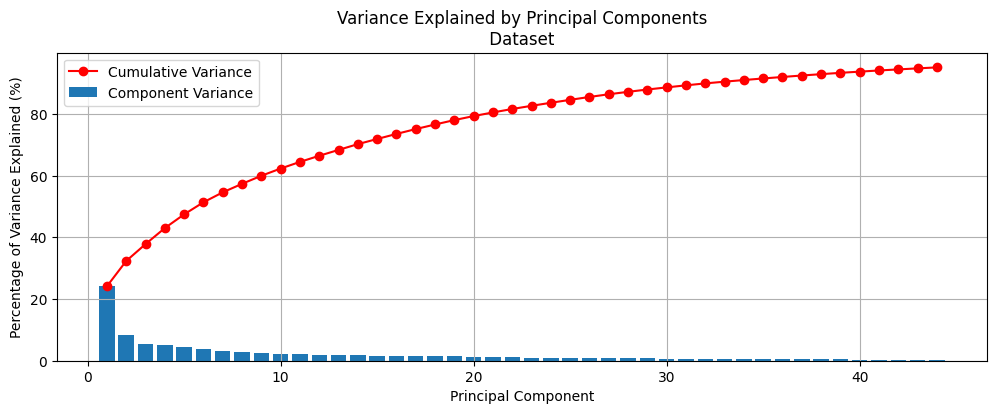

x_train_data head <bound method NDFrame.head of           pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0     -0.147713 -0.126049 -0.036017 -0.045703 -0.015438 -0.039117 -0.012555   
1     -0.154213 -0.145199 -0.046457 -0.060138 -0.022125 -0.063145 -0.028844   
2     -0.149175 -0.126545 -0.036201 -0.046411 -0.015625 -0.042044 -0.013658   
3     -0.149358 -0.126607 -0.036224 -0.046499 -0.015649 -0.042410 -0.013795   
4     -0.148627 -0.126359 -0.036132 -0.046145 -0.015555 -0.040946 -0.013244   
...         ...       ...       ...       ...       ...       ...       ...   
13873 -0.149266 -0.126576 -0.036213 -0.046455 -0.015637 -0.042227 -0.013727   
13874 -0.149266 -0.126576 -0.036213 -0.046455 -0.015637 -0.042227 -0.013727   
13875 -0.009599 -0.091188 -0.029275  0.070200 -0.027290  0.319624  0.839506   
13876 -0.171746 -0.032903  0.288543  0.188128  0.216257 -0.037180  0.030806   
13877 -0.149358 -0.126607 -0.036224 -0.046499 -0.015649 -0.042410 -0.013795   

   

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0, 
                      Mean Generator Loss: 1.0810818672180176, 
                     Mean Discriminator Loss: 1.4049911499023438
                      Generator Loss: 1.081, 
                      Discriminators Loss: [D1 loss: 1.405                      Took 12.433019638061523 seconds. 


Epoch: 100, 
                      Mean Generator Loss: 1.1997522115707397, 
                     Mean Discriminator Loss: 0.7599457493512938
                      Generator Loss: 1.179, 
                      Discriminators Loss: [D1 loss: 0.319                      Took 0.17116403579711914 seconds. 


Epoch: 200, 
                      Mean Generator Loss: 1.1438666445698904, 
                     Mean Discriminator Loss: 0.6496143120141765
                      Generator Loss: 1.011, 
                      Discriminators Loss: [D1 loss: 0.524                      Took 0.18603229522705078 seconds. 


Epoch: 300, 
                      Mean Generator Loss: 1.0968276482087829, 
           

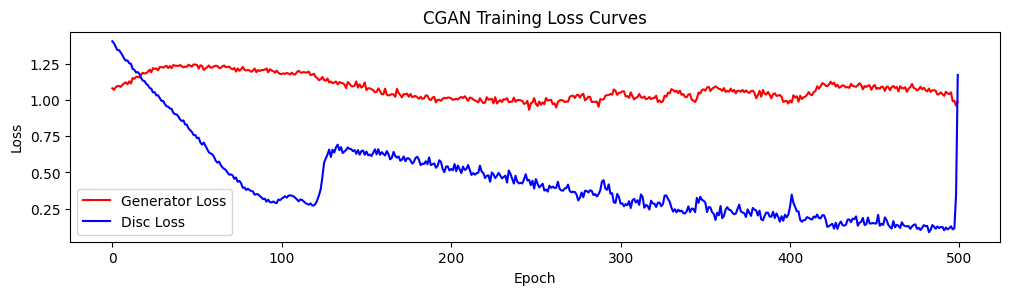

--- plot_3discs ---


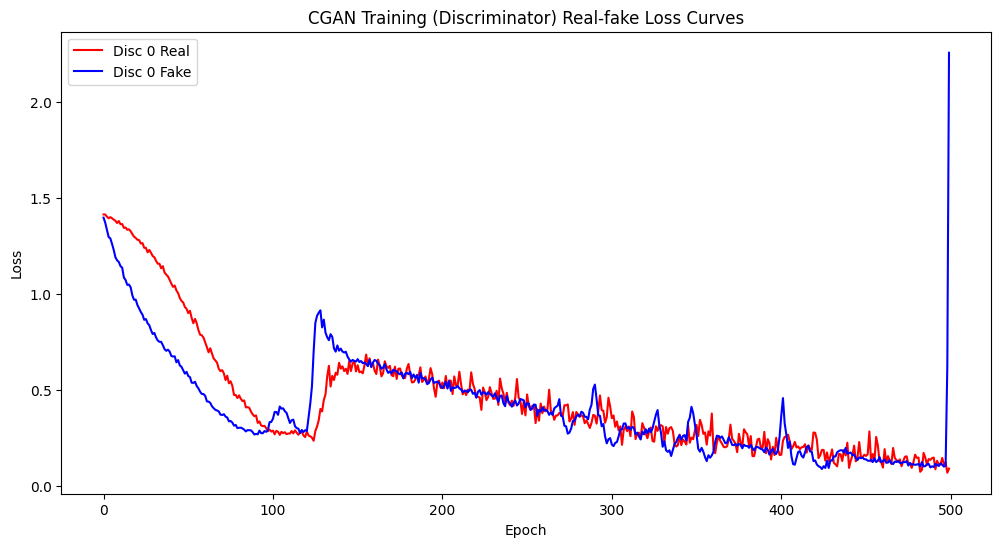


Memory Usage: 22.2%

------------ Balance Data Using CGAN ------------
------------ balance_data_using_cgan (int) ------------
y_data :     attack_type
0            0
1            0
2            1
3            0
4            1
5            1
6            0
7            0
8            0
9            0
labels_dic:  attack_type
1              3009
0              2939
Name: count, dtype: int64
max_class_sample:  3009 
goal_rows_per_class:  3009
num_samples_to_generate :  0
num_samples_to_generate :  70
We generate 70 synthetic samples for attack_type label (0,)
noise:  (70, 44)
generated_labels:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
generated_data.shape:  (70, 44)
labels_dic 2 len :  2
10
12
x_synthetic_data shape :  (70, 44)
y_synthetic_data shape :  (70, 1)
x_synthetic_data head :  <bound method NDFrame.head of            pca_1     pca_2         pca_3         pca_4         pca_5  \
0   2.797352e-11  0.940758  8.522709e-08  6.127271e-27  2.131884e-14   
1   8.459255e-12  0.94620

In [ ]:

# ---------------------------> Definition <--------------------------- #
"""
BATCH_SIZE = 128      #30   #batch_size = 16
NUM_EPOCHS = 500      # epoch_count = 50
#noise_dim = 100
#n_class = 10

# Save losses for plotting
cd_real_losses = []   # Real Data D losses
cd_fake_losses = []   # Fake data D losses
cd_losses      = []   # discriminator (D) losses
cg_losses      = []   # generator losses
"""

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")



# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100 #30 #100
max_rows = 20000
data = read_csv_files(dataset_directory, percent, max_rows)
print('len data : ' , len(data))


class_Col = 'attack_type'

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")



# >> ---------------------------> Balance Data Before Start <--------------------------- #
#min_rows_per_class = 2000  #50000
#df_balanced_before = balance_data_before_cgan(data, class_Col, min_rows_per_class)
#data = df_balanced_before


# Balance the dataset
df_SQLi = data[data[class_Col] == 1]
df_normal = data[data[class_Col] == 0]

# Balance by sampling from the smaller class
min_len = min(len(df_SQLi), len(df_normal))
balanced_data = pd.concat([df_SQLi.sample(min_len), df_normal.sample(min_len)], ignore_index=True)
print('Balanced data length:', len(balanced_data))

# Replace `data` with `balanced_data` for further processing
data = balanced_data



# ---------------------------> Apply pre-processing <--------------------------- #
main_text_col = 'sentence'
n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test, y_datatype = load_and_preprocess_data1(data)        ## pre-process way 2
num_classes = n_classes
print('-- End pre-process --')


del data, origin_x_train, origin_x_test      # delete no longer vars need
gc.collect()  # Free memory

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")




# ---------------------------> Run CGAN Models (Gen., Disc., Comb.) - run_CGAN_models(old) <--------------------------- #
input_dim = x_train_data.shape[1]     # (features_dim) Dimensionality of TF-IDF vectors
print('features_dim shape: ', input_dim)

## Build the generator
print('G input_dim: ', input_dim)

generator_model = build_generator(input_dim, num_classes)   # random_noise_size / input_shape / input_dim

## Build a discriminator ( disc.)
discriminators_model = []
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator', 3, [100, 100, 100], 0.1))

## Build the combined model (GAN Model)
combined_model = build_combined_model(input_dim, num_classes, generator_model, discriminators_model)



# ---------------------------> print_models_summary <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")

## Generator Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (CGAN): \n{TextStyle.RESET_ALL}")
generator_model.summary(show_trainable=True,expand_nested=True)   #generator_model.summary()

## Discriminators Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (CGAN): \n{TextStyle.RESET_ALL}")
discriminators_model[0].summary(show_trainable=True,expand_nested=True)

## Combined Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (CGAN):\n{TextStyle.RESET_ALL} ")
combined_model.summary(show_trainable=True)


# ---------------------------> Plot Architecture <--------------------------- #
plot_architecture(generator_model, combined_model, discriminators_model)

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")



# ---------------------------> Train Model <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ train_model ------------{TextStyle.RESET_ALL}")
batch_size = BATCH_SIZE       # 128
noise_dim = input_dim
one_hot_encoder = train_cgan(BATCH_SIZE, noise_dim, num_classes, generator_model, discriminators_model, combined_model, x_train_data, y_train, NUM_EPOCHS)


del x_train_data, y_train
gc.collect()  # Free memory

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")






# >> ---------------------------> Balance Data Using CGAN <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Balance Data Using CGAN ------------{TextStyle.RESET_ALL}")

# x_test_data  ,  y_test


goal_rows_per_class = 1000
features_test_cols = x_test_data.columns
#print('x_test_data shape : ', x_test_data.shape)
#print('count features_test_cols: ', len(features_test_cols))
#print('features_test_cols : ' , features_test_cols)

x_synthetic_data, y_synthetic_data, synthetic_data = balance_data_using_cgan(y_test, input_dim, features_test_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)


# add colum clear instance is real data or fake to help compare in evaluate step
# can't assume all real (1) m because we add new synthetic_data (fake) to them
y_test['is_real'] = np.ones(y_test.shape[0])
print('y_test.shape[0] : ', y_test.shape[0])

y_synthetic_data['is_real'] = np.zeros(y_synthetic_data.shape[0])


# Concatenate synthetic samples with the original dataset
new_x_test_data = pd.concat([x_test_data, x_synthetic_data], ignore_index=True, sort=False)
new_y_test_data = pd.concat([y_test, y_synthetic_data], ignore_index=True, sort=False)

print('x_test_data shape : ' , x_test_data.shape)
print('y_test shape : ' , y_test.shape)
print('x_synthetic_data shape : ' , x_synthetic_data.shape)
print('y_synthetic_data shape : ' , y_synthetic_data.shape)

print('new_x_test_data : ' , new_x_test_data[:10])
print('new_y_test_data : ' , new_y_test_data[:10])
print('new_x_test_data shape : ' , new_x_test_data.shape)
print('new_y_test_data shape : ' , new_y_test_data.shape)


del x_test_data, x_synthetic_data, y_test, y_synthetic_data
gc.collect()  # Free memory

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")



# x_test_data  ,  y_test
#new_x_test_data = x_test_data
#new_y_test_data = y_test

# ---------------------------> Evaluate Model <--------------------------- #
evaluate_cgan(new_x_test_data, new_y_test_data, n_classes, batch_size, one_hot_encoder, y_datatype)
#evaluate_cgan_test(generator_model, discriminators_model, new_x_test_data, new_y_test_data, noise_dim, batch_size, one_hot_encoder)


gc.collect()  # Free memory

print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}\nMemory Usage: {psutil.virtual_memory().percent}%\n{TextStyle.RESET_ALL}")





# ---------------------------> Evaluate Other Models <--------------------------- #
# x_train_data      => retun from pre-pocess (load_and_preprocess_data1)
# new_x_test_data   => concate between ( x_test_data from pe-process)  &  (x_synthetic_data from balancing data using gan (balance_data_using_gan) )
# y_train           => retun from pre-pocess (load_and_preprocess_data1)
# new_y_test_data   => concate between ( y_test from pe-process)  &  (y_synthetic_data from balancing data using gan (balance_data_using_gan) )
# one_hot_encoder   => from train_model

###other_models_performance(x_train_data, new_x_test_data, y_train, new_y_test_data, one_hot_encoder)

